<a href="https://colab.research.google.com/github/sugarforever/LangChain-Tutorials/blob/main/langgraph_nodes_edges.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install -q -U langchain langchain_openai langgraph google-search-results

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

True

In [3]:
os.environ['SERPAPI_API_KEY'] = os.getenv('SERPAPI_API_KEY')
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['LANGCHAIN_TRACING_V2'] = os.getenv('LANGCHAIN_TRACING_V2')
os.environ['LANGCHAIN_ENDPOINT'] = os.getenv('LANGCHAIN_ENDPOINT')
os.environ['LANGCHAIN_API_KEY'] = os.getenv('LANGCHAIN_API_KEY')
os.environ['LANGCHAIN_PROJECT'] = os.getenv('LANGCHAIN_PROJECT')

In [4]:
from langchain_community.utilities import SerpAPIWrapper

In [5]:
search = SerpAPIWrapper()

search.run("Obama's first name?")

'Barack Hussein Obama II'

In [6]:
import functools, operator, requests, os, json
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END
from langchain.tools import tool
from langchain_ollama import ChatOllama
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict

In [17]:
llm = ChatOllama(model='llama3.2:3b')

In [18]:
from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    ChatMessage,
    FunctionMessage,
    HumanMessage,
    SystemMessage
)

@tool("web_search")
def web_search(query: str) -> str:
    """Search with Google SERP API by a query"""
    search = SerpAPIWrapper()
    return search.run(query)

@tool("twitter_writer")
def write_tweet(content: str) -> str:
    """Based a piece of content, write a tweet."""
    chat = ChatOllama()
    messages = [
      SystemMessage(
          content="You are a Twitter account operator."
                  " You are responsible for writing a tweet based on the content given."
                  " You should follow the Twitter policy and make sure each tweet has no more than 140 characters."
      ),
      HumanMessage(
          content=content
      ),
    ]
    response = chat(messages)
    return response.content

In [19]:
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str

In [20]:
def create_agent(llm: ChatOllama, tools: list, system_prompt: str):
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

In [21]:
members = ["Search_Engine", "Twitter_Writer"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

options = ["FINISH"] + members
# Using openai function calling can make output parsing easier for us
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

supervisor_chain = (
    prompt
    | llm.bind(functions=[function_def], function_call="route")
    #| llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

In [22]:
search_engine_agent = create_agent(llm, [web_search], "You are a web search engine.")
search_engine_node = functools.partial(agent_node, agent=search_engine_agent, name="Search_Engine")

twitter_operator_agent = create_agent(llm, [write_tweet], "You are responsible for writing a tweet based on the content given.")
twitter_operator_node = functools.partial(agent_node, agent=twitter_operator_agent, name="Twitter_Writer")

workflow = StateGraph(AgentState)
workflow.add_node("Search_Engine", search_engine_node)
workflow.add_node("Twitter_Writer", twitter_operator_node)
workflow.add_node("supervisor", supervisor_chain)

In [23]:
for member in members:
    workflow.add_edge(member, "supervisor")

conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)

workflow.set_entry_point("supervisor")

graph = workflow.compile()

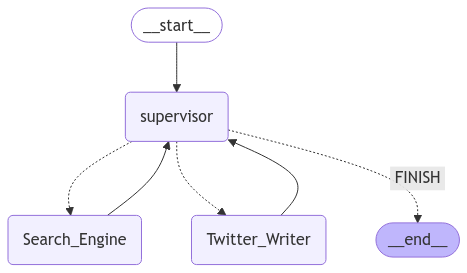

In [24]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Write a tweet about airport news")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")